<a href="https://colab.research.google.com/github/adolfoguimaraes/datascience/blob/main/code/13_laboratorio_redesneurais2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - CNN 

Essa atividade tem como objetivo criar um modelo de reconhecimento de imagem utilizando a CNN.



## Treinamento da Rede CNN

O primeiro passo da atividade é treinar um modelo capaz de classificar imagens. Para isso, vamos utilizar o modelo CNN apresentado na aula passada. Todo material da CNN apresentado aqui é retirado do curso da Udacity [Deep Learning com PyTorch](https://learn.udacity.com/courses/ud188/). O notebook é uma tradução do notebook original do curso. 



### Teste para o CUDA

O treinamento de uma rede desse tipo com o conjunto de imagens (32x32x3) pode ser custoso para ser executado em uma CPU. Dessa forma, a proposta é executar o exercício utilizando a GPU. Para isso vamos usar o CUDA, framework de computação paralela. A vantagem é que os Tensors em CUDA são idênticos aos Tensors tradicionais. No entanto, utiliza a GPU para computação. 

In [ ]:

# Para ativar a GPU accese Runtime > Runtime Type

import torch 
import numpy as np 

# Verifica se o CUDA está disponível

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA não está disponível. Treinando com CPU ...")
else:
  print("CUDA está disponível. Treinando com GPU ...")


CUDA não está disponível. Treinando com CPU ...


### Carregar os dados

Os dados são  carregados pelo próprio PyTorch e consiste na base [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). A base vai ser carregada em treino e teste. A base  de treino será dividida em treinamento e valiadação. A imagem a seguir mostra um pouco da base que vai ser utilizada:

<img src='https://github.com/udacity/deep-learning-v2-pytorch/raw/a60c71ad0c8cef9f4f5d96358162014f920c648a/convolutional-neural-networks/cifar-cnn/notebook_ims/cifar_data.png' width=50% height=50% />

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# número de subprocessos usados para carregar os dados
num_workers = 0
# quantas instâncias serão carregadas por batch
batch_size = 20

# percentagem do treinamento que será usada para validação
valid_size = 0.2

# converte os dados em um torch.FloatTensor e normaliza os valores 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Carrega os dados de treino e teste
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtém os índices do treino que serão utilizados para validação
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


# determina as amostrar para obter os batches de treino e validação
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
dict_class = dict(enumerate(classes))
dict_class

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

### Visualizando um Batch dos dados de treinamento



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

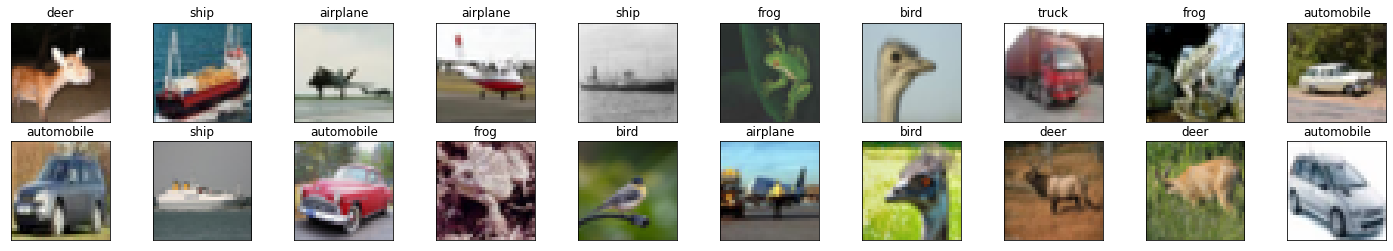

In [ ]:
# obtem um batch do treinamentoo
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plota as imagens do batch com seus labels
fig = plt.figure(figsize=(25, 4))
# mostra 20 imagens
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Visualizar uma imagem com mais detalhes



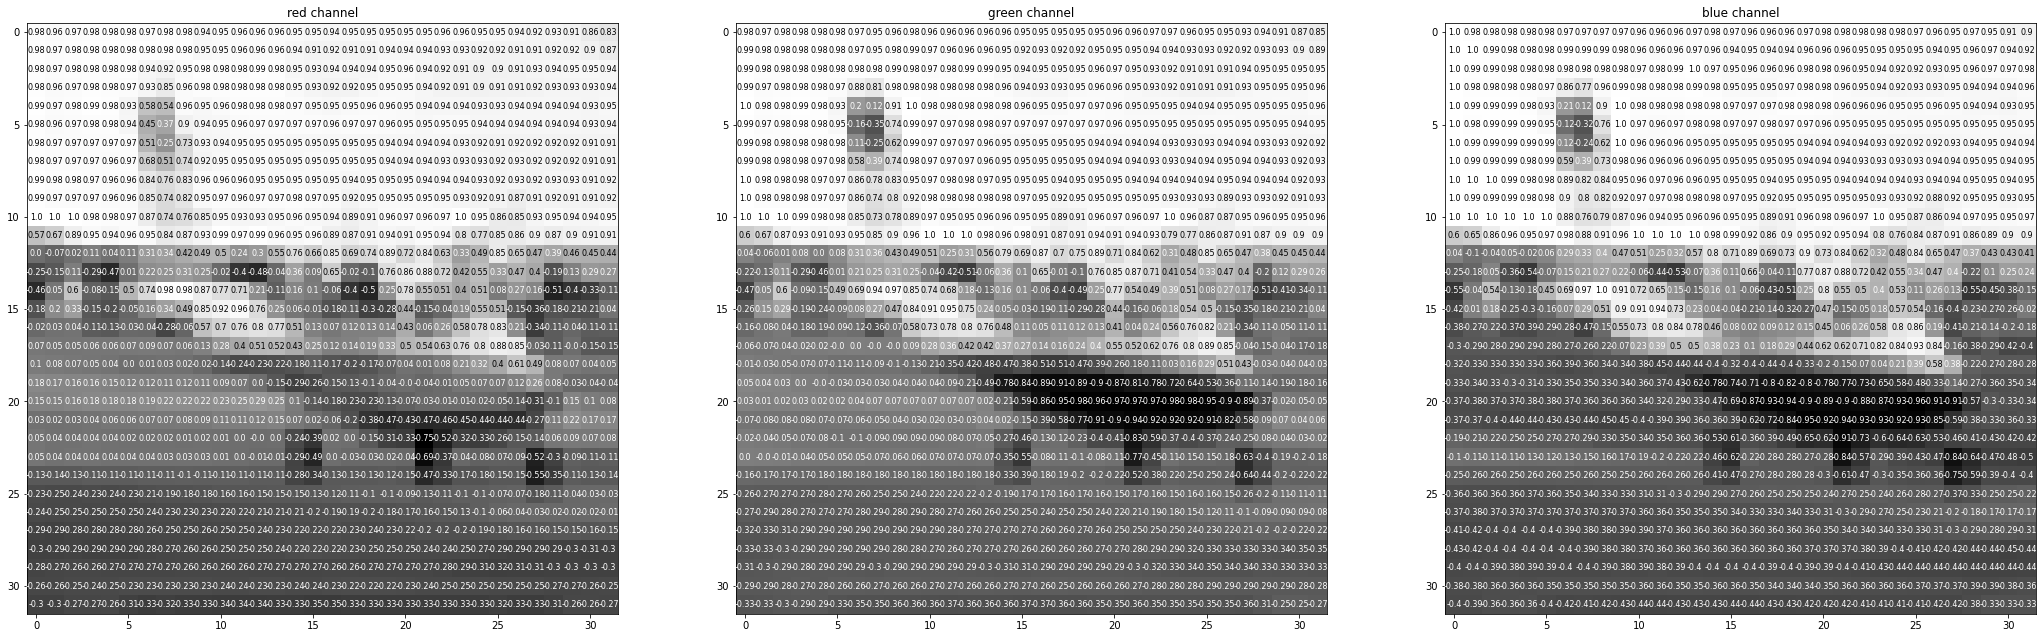

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

### Definindo a arquitetura

Agora vamos definir a arquitetura da CNN. Ao invés de uma MLP, que usa camadas lineares e totalmente conectadas, a CNN tem as seguintes camadas: 

* **Camada convolucional** que consiste em uma pilha de imagens filtradas;
* **Camada de Maxpooling** que reduz a entrada mantendo apenas os pixels mais _ativos_ da camada anterior;
* **Camada linear** que é camada linear tradicional com Dropout para evitar o overfitting. Essa camada produz como saída um vetor de 10 posições.

A imagem a seguir mostra a rede que vai ser construída.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/raw/a60c71ad0c8cef9f4f5d96358162014f920c648a/convolutional-neural-networks/cifar-cnn/notebook_ims/2_layer_conv.png'  />

Vamos definir uma rede com múltiplas camadas convolucionai. Quanto mais camadas convolucionais sua rede possuir, mais complexos são os padrões de cores e formas que podem ser detectadas. Sugere-se que sua rede tenha de 2 a 3 camadas convolucionais com uma camada linear com dropout para evitar overfitting. 

É uma boa prática olhar para pesquisas e implementações existentes de modelos relacionados para definir a configuração inicial de seu modelo. Os links a seguir podem ser úteis neste processo para decidir sua arquitetura:

* [Classificação com PyTorch](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py)
* [Um exemplo mais complexo com Keras](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)







In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


O passo seguinte é definir a função de erro e o otimizador do nosso modelo.

In [ ]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

Agora é hora de treinar o modelo. Importante olhar como a perda de treinamento e validação se comportam ao longo de treinamento. Se a perda da validação aumentar, isso pode indicar o caso de _overfitting_. 

In [ ]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.091141 	Validation Loss: 1.819156
Validation loss decreased (inf --> 1.819156).  Saving model ...
Epoch: 2 	Training Loss: 1.672653 	Validation Loss: 1.500257
Validation loss decreased (1.819156 --> 1.500257).  Saving model ...
Epoch: 3 	Training Loss: 1.488762 	Validation Loss: 1.429673
Validation loss decreased (1.500257 --> 1.429673).  Saving model ...
Epoch: 4 	Training Loss: 1.372137 	Validation Loss: 1.287383
Validation loss decreased (1.429673 --> 1.287383).  Saving model ...
Epoch: 5 	Training Loss: 1.277780 	Validation Loss: 1.199610
Validation loss decreased (1.287383 --> 1.199610).  Saving model ...
Epoch: 6 	Training Loss: 1.197132 	Validation Loss: 1.115550
Validation loss decreased (1.199610 --> 1.115550).  Saving model ...
Epoch: 7 	Training Loss: 1.126896 	Validation Loss: 1.093823
Validation loss decreased (1.115550 --> 1.093823).  Saving model ...
Epoch: 8 	Training Loss: 1.066520 	Validation Loss: 1.056451
Validation loss decreased (1.09382

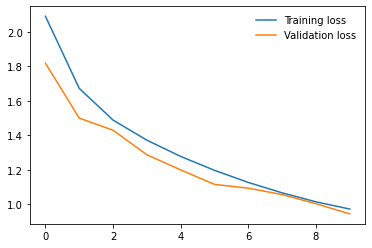

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend(frameon=False)

### Carregando o modelo salvo

A medida que o treinamento era executado, o melhor modelo encontrado era salvo em disco. Vamos testa-la na base de testes.

In [ ]:
model.load_state_dict(torch.load("model_cifar.pt"))

<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Coloca no modo avaliação
model.eval()

# itera sobre os dados de teste
for batch_idx, (data, target) in enumerate(test_loader):
    
    # move os tensors para a GPU, caso CUDA esteja ativado
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    # computa a saída dado os dados de entrada
    output = model(data)

    # calcula o erro do batch
    loss = criterion(output, target)

    # atualiza o erro do teste
    test_loss += loss.item()*data.size(0)

    # converte a saída da rede na classe 
    _, pred = torch.max(output, 1)    

    # compara a saída com o gabarito

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # calcula a acurácia do teste, para cada classe 
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Média do erro na base de teste
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.935428

Test Accuracy of airplane: 68% (683/1000)
Test Accuracy of automobile: 77% (773/1000)
Test Accuracy of  bird: 56% (568/1000)
Test Accuracy of   cat: 54% (543/1000)
Test Accuracy of  deer: 58% (581/1000)
Test Accuracy of   dog: 51% (519/1000)
Test Accuracy of  frog: 76% (767/1000)
Test Accuracy of horse: 67% (677/1000)
Test Accuracy of  ship: 87% (875/1000)
Test Accuracy of truck: 72% (722/1000)

Test Accuracy (Overall): 67% (6708/10000)


### Visualizando os resultados do teste



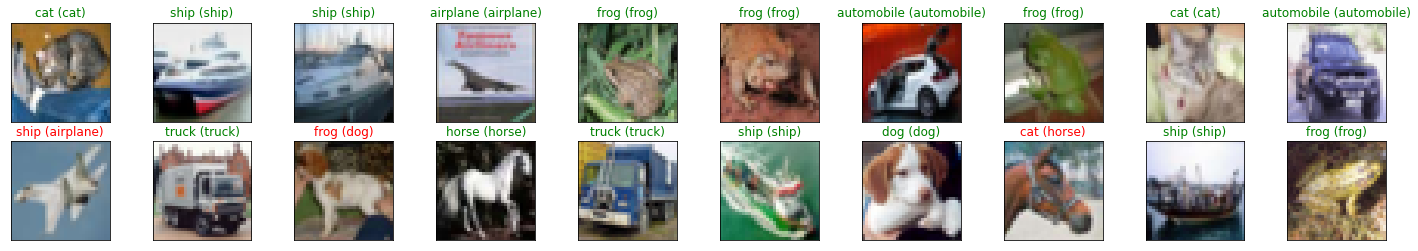

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()


# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### Testando com uma imagem externa

In [ ]:
from PIL import Image
from torch.autograd import Variable

imsize = (32,32)
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])


def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

image = image_loader("img_test/dog1.jpeg")

output = model(image)
_, pred = torch.max(output, 1)    
dict_class[int(pred[0])]


'ship'